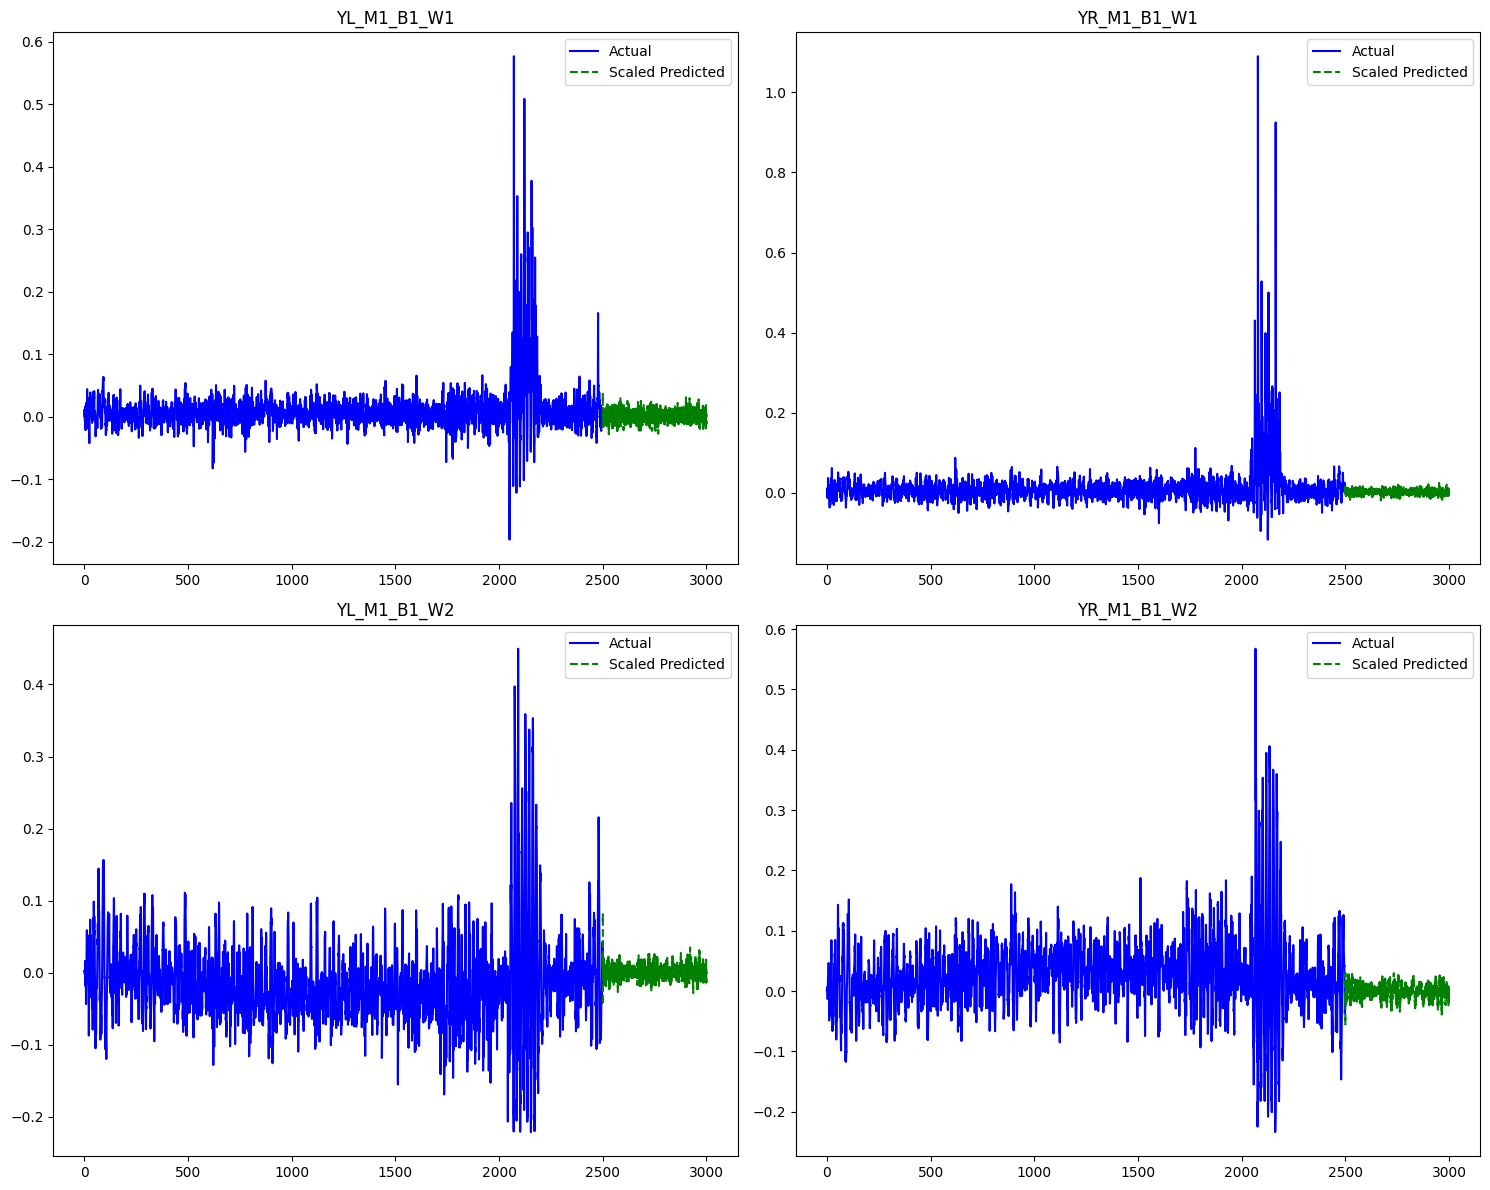

In [ ]:
# 필요한 라이브러리들 불러오기
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 데이터 불러오기
train_data_path = "data_c30.csv"
lane_data_path = "lane_data_c.csv"

train_data = pd.read_csv(train_data_path)
lane_data = pd.read_csv(lane_data_path)

# Train 데이터에 대한 전처리: Distance를 기준으로 학습 데이터와 선로 데이터 병합
merged_data = pd.merge(train_data, lane_data, on="Distance", how="left")

# Distance 2500~3000 범위를 예측 대상으로 분리
test_data = merged_data[merged_data["Distance"] >= 2500].copy()
train_data = merged_data[merged_data["Distance"] < 2500].copy()

# 데이터 변환 함수 정의
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, -4:])
    return np.array(dataX), np.array(dataY)

# 데이터 변환 수행
features = merged_data.columns.difference(["YL_M1_B1_W1", "YR_M1_B1_W1", "YL_M1_B1_W2", "YR_M1_B1_W2", "Distance"]).to_list()
look_back = 5
X_seq, y_seq = create_dataset(merged_data[features + ["YL_M1_B1_W1", "YR_M1_B1_W1", "YL_M1_B1_W2", "YR_M1_B1_W2"]].values, look_back)

# 학습 및 예측 데이터 분리
X_train_seq = X_seq[:len(train_data) - look_back]
y_train_seq = y_seq[:len(train_data) - look_back]
X_test_seq = X_seq[len(train_data) - look_back:]
y_test_seq = y_seq[len(train_data) - look_back:]

# 선형 회귀 모델 학습
partial_train_size = 500
X_train_partial = X_train_seq[-partial_train_size:]
y_train_partial = y_train_seq[-partial_train_size:]
X_train_partial_reshaped = X_train_partial.reshape((X_train_partial.shape[0], -1))
X_test_seq_reshaped = X_test_seq.reshape((X_test_seq.shape[0], -1))

linear_model = LinearRegression()
linear_model.fit(X_train_partial_reshaped, y_train_partial)
predictions_linear = linear_model.predict(X_test_seq_reshaped)

# 곡률에 따른 스케일 팩터 계산
max_curvature = lane_data["Curvature"].max()
min_curvature = lane_data["Curvature"].min()
scale_factor_range = (1, 1.5)
lane_data["scale_factor"] = lane_data["Curvature"].apply(lambda x: ((x - min_curvature) / (max_curvature - min_curvature) * (scale_factor_range[1] - scale_factor_range[0])) + scale_factor_range[0])

# 스케일 팩터로 예측값 조정
scaled_predictions = predictions_linear.copy()
for i, distance in enumerate(test_data["Distance"]):
    scale_factor = lane_data[lane_data["Distance"] == distance]["scale_factor"].values[0]
    scaled_predictions[i] *= scale_factor

# 결과 시각화
plt.figure(figsize=(15, 12))
target_columns = ["YL_M1_B1_W1", "YR_M1_B1_W1", "YL_M1_B1_W2", "YR_M1_B1_W2"]
for idx, col in enumerate(target_columns, 1):
    plt.subplot(2, 2, idx)
    plt.plot(train_data["Distance"], train_data[col], label='Actual', color='blue')
    plt.plot(test_data["Distance"], scaled_predictions[:, idx - 1], label='Scaled Predicted', color='green', linestyle='dashed')
    plt.title(col)
    plt.legend()

plt.tight_layout()
plt.show()


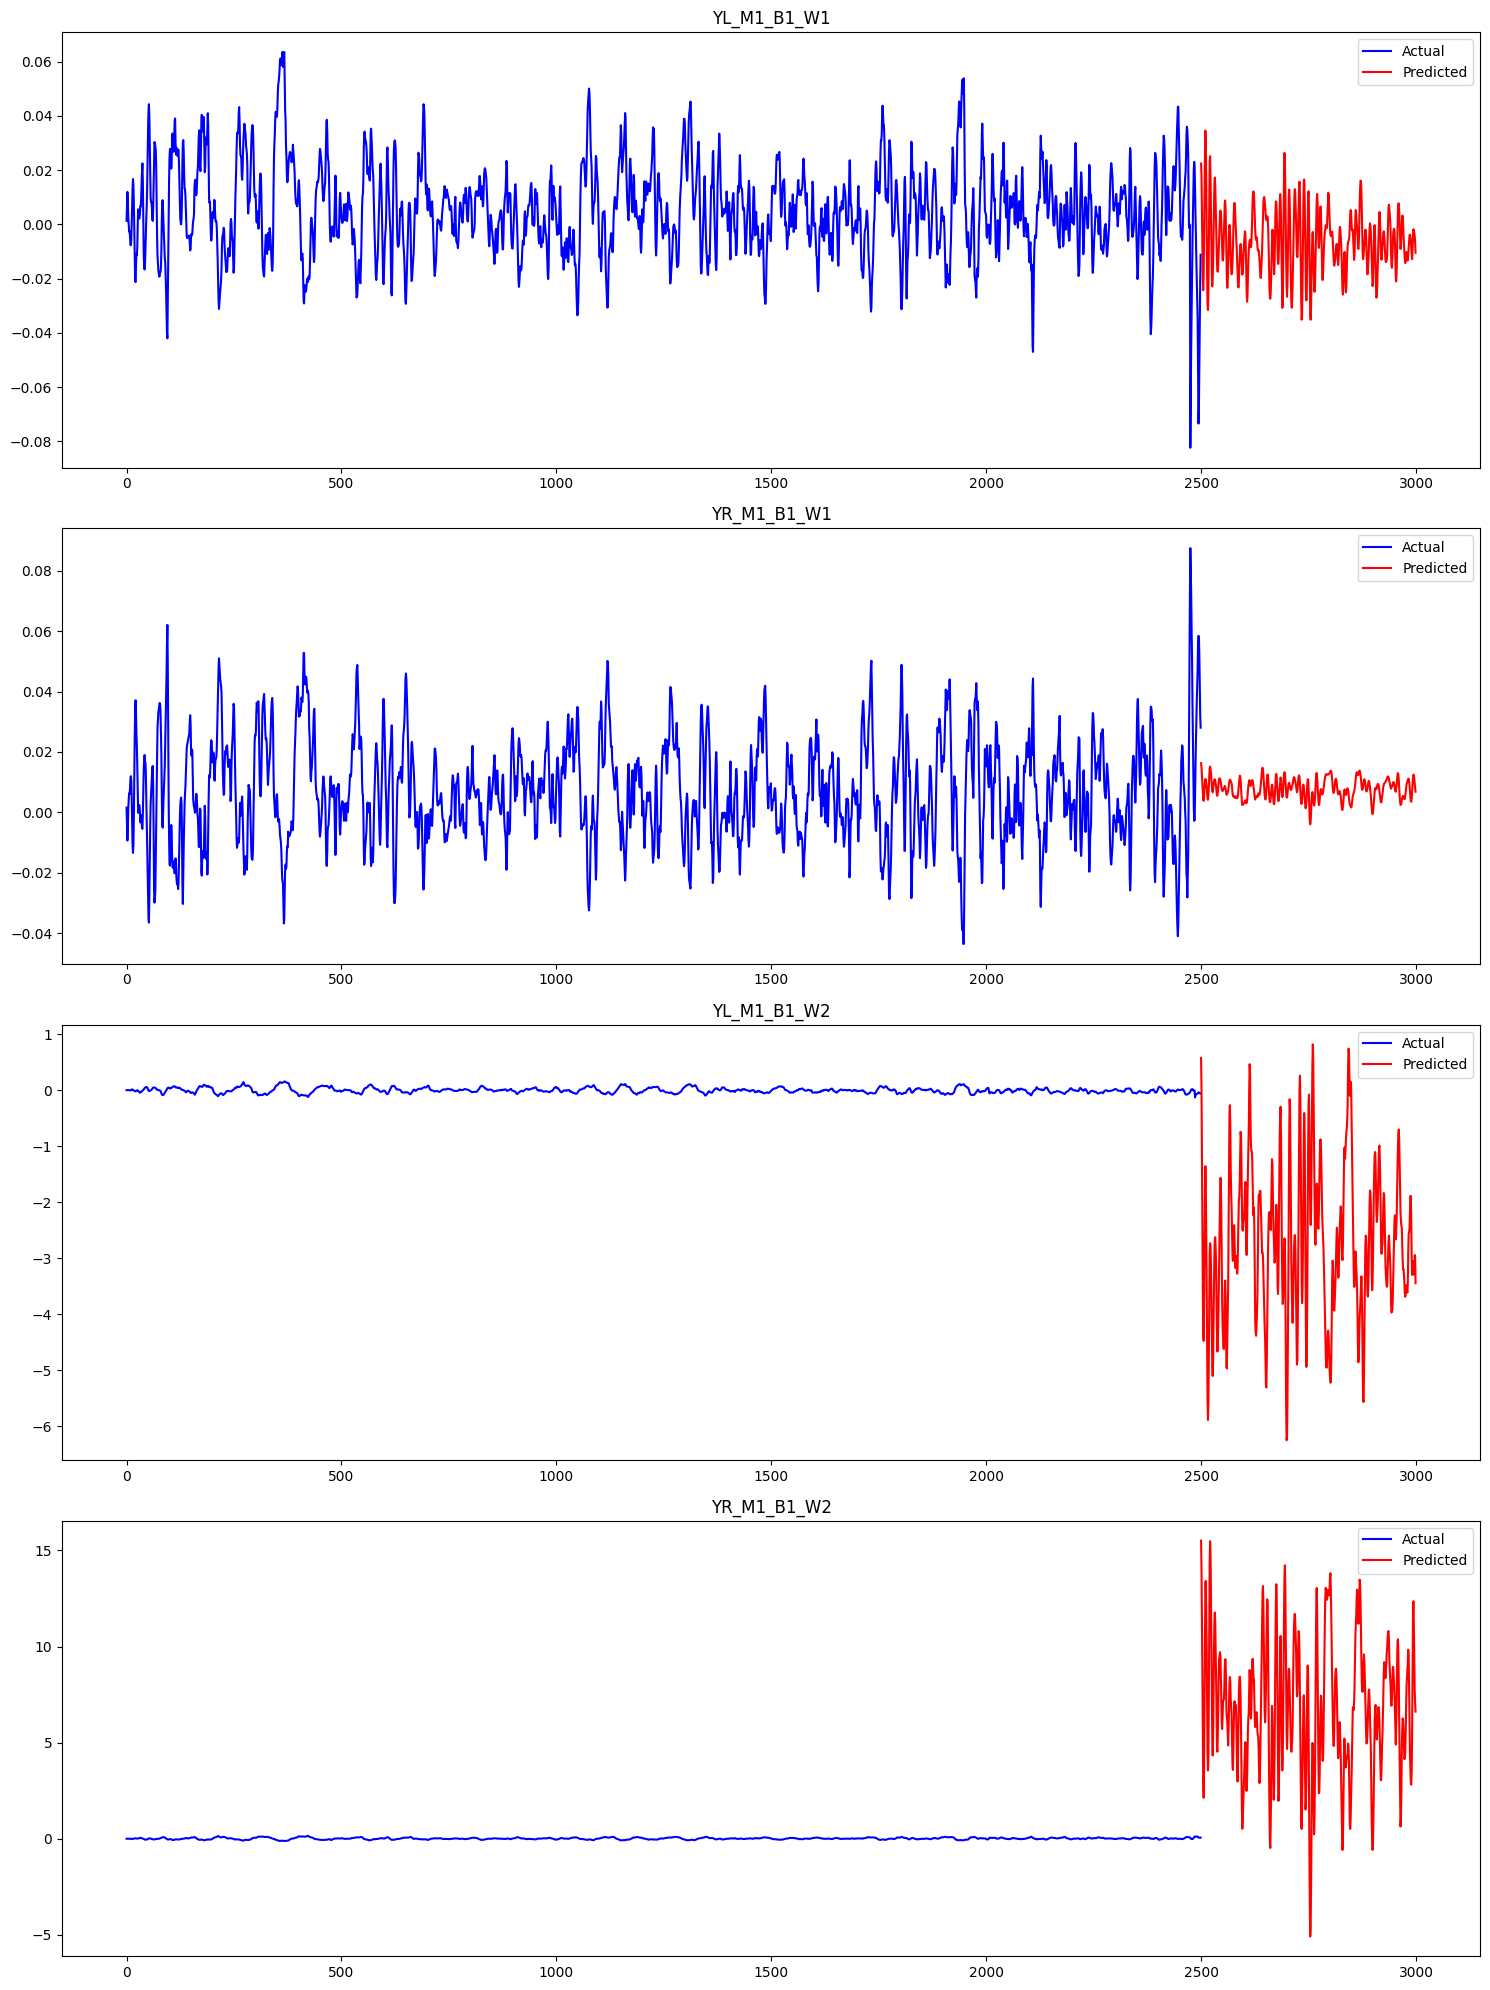

In [45]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 데이터 불러오기
train_data_path = "data_c30.csv"
lane_data_path = "lane_data_c.csv"

train_data = pd.read_csv(train_data_path)
lane_data = pd.read_csv(lane_data_path)

# Train 데이터에 대한 전처리: Distance를 기준으로 학습 데이터와 선로 데이터 병합
merged_data = pd.merge(train_data, lane_data, on="Distance", how="left")

# NaN 값은 0으로 대체
merged_data = merged_data.fillna(0)

# LSTM 입력 데이터 생성 함수
def create_dataset(data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(data)-look_back):
        dataX.append(data[i:(i+look_back)])
        dataY.append(data[i + look_back, -4:])
    return np.array(dataX), np.array(dataY)

# 스케일링
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data)

# LSTM 입력 데이터 생성
look_back = 5

X, y = create_dataset(scaled_data, look_back)

# 데이터 분리
split_idx = len(scaled_data) - 500 - look_back
X_train = torch.tensor(X[:split_idx], dtype=torch.float32)
y_train = torch.tensor(y[:split_idx], dtype=torch.float32)
X_test = torch.tensor(X[split_idx:], dtype=torch.float32)
y_test = torch.tensor(y[split_idx:], dtype=torch.float32)

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out

model = LSTMModel(input_dim=X_train.shape[2], hidden_dim=50, output_dim=4, num_layers=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 50
for epoch in range(num_epochs):
    outputs = model(X_train)
    optimizer.zero_grad()

    # 손실 계산
    loss = criterion(outputs, y_train)

    # Backward pass
    loss.backward()
    optimizer.step()

# 예측 수행
model.eval()
with torch.no_grad():
    predictions = model(X_test)

# 스케일링 되돌리기
predicted_values = np.zeros_like(scaled_data)
predicted_values[-500:,-4:] = predictions.numpy()
predicted_values = scaler.inverse_transform(predicted_values)
final_predictions = predicted_values[-500:,-4:]

# 그래프 출력
fig, axes = plt.subplots(4, 1, figsize=(15, 20))

# YL_M1_B1_W1
axes[0].plot(range(2500), merged_data["YL_M1_B1_W1"].values[:2500], label="Actual", color="blue")
axes[0].plot(range(2500, 3000), final_predictions[:, 0], label="Predicted", color="red")
axes[0].set_title("YL_M1_B1_W1")
axes[0].legend()

# YR_M1_B1_W1
axes[1].plot(range(2500), merged_data["YR_M1_B1_W1"].values[:2500], label="Actual", color="blue")
axes[1].plot(range(2500, 3000), final_predictions[:, 1], label="Predicted", color="red")
axes[1].set_title("YR_M1_B1_W1")
axes[1].legend()

# YL_M1_B1_W2
axes[2].plot(range(2500), merged_data["YL_M1_B1_W2"].values[:2500], label="Actual", color="blue")
axes[2].plot(range(2500, 3000), final_predictions[:, 2], label="Predicted", color="red")
axes[2].set_title("YL_M1_B1_W2")
axes[2].legend()

# YR_M1_B1_W2
axes[3].plot(range(2500), merged_data["YR_M1_B1_W2"].values[:2500], label="Actual", color="blue")
axes[3].plot(range(2500, 3000), final_predictions[:, 3], label="Predicted", color="red")
axes[3].set_title("YR_M1_B1_W2")
axes[3].legend()

plt.tight_layout()
plt.show()


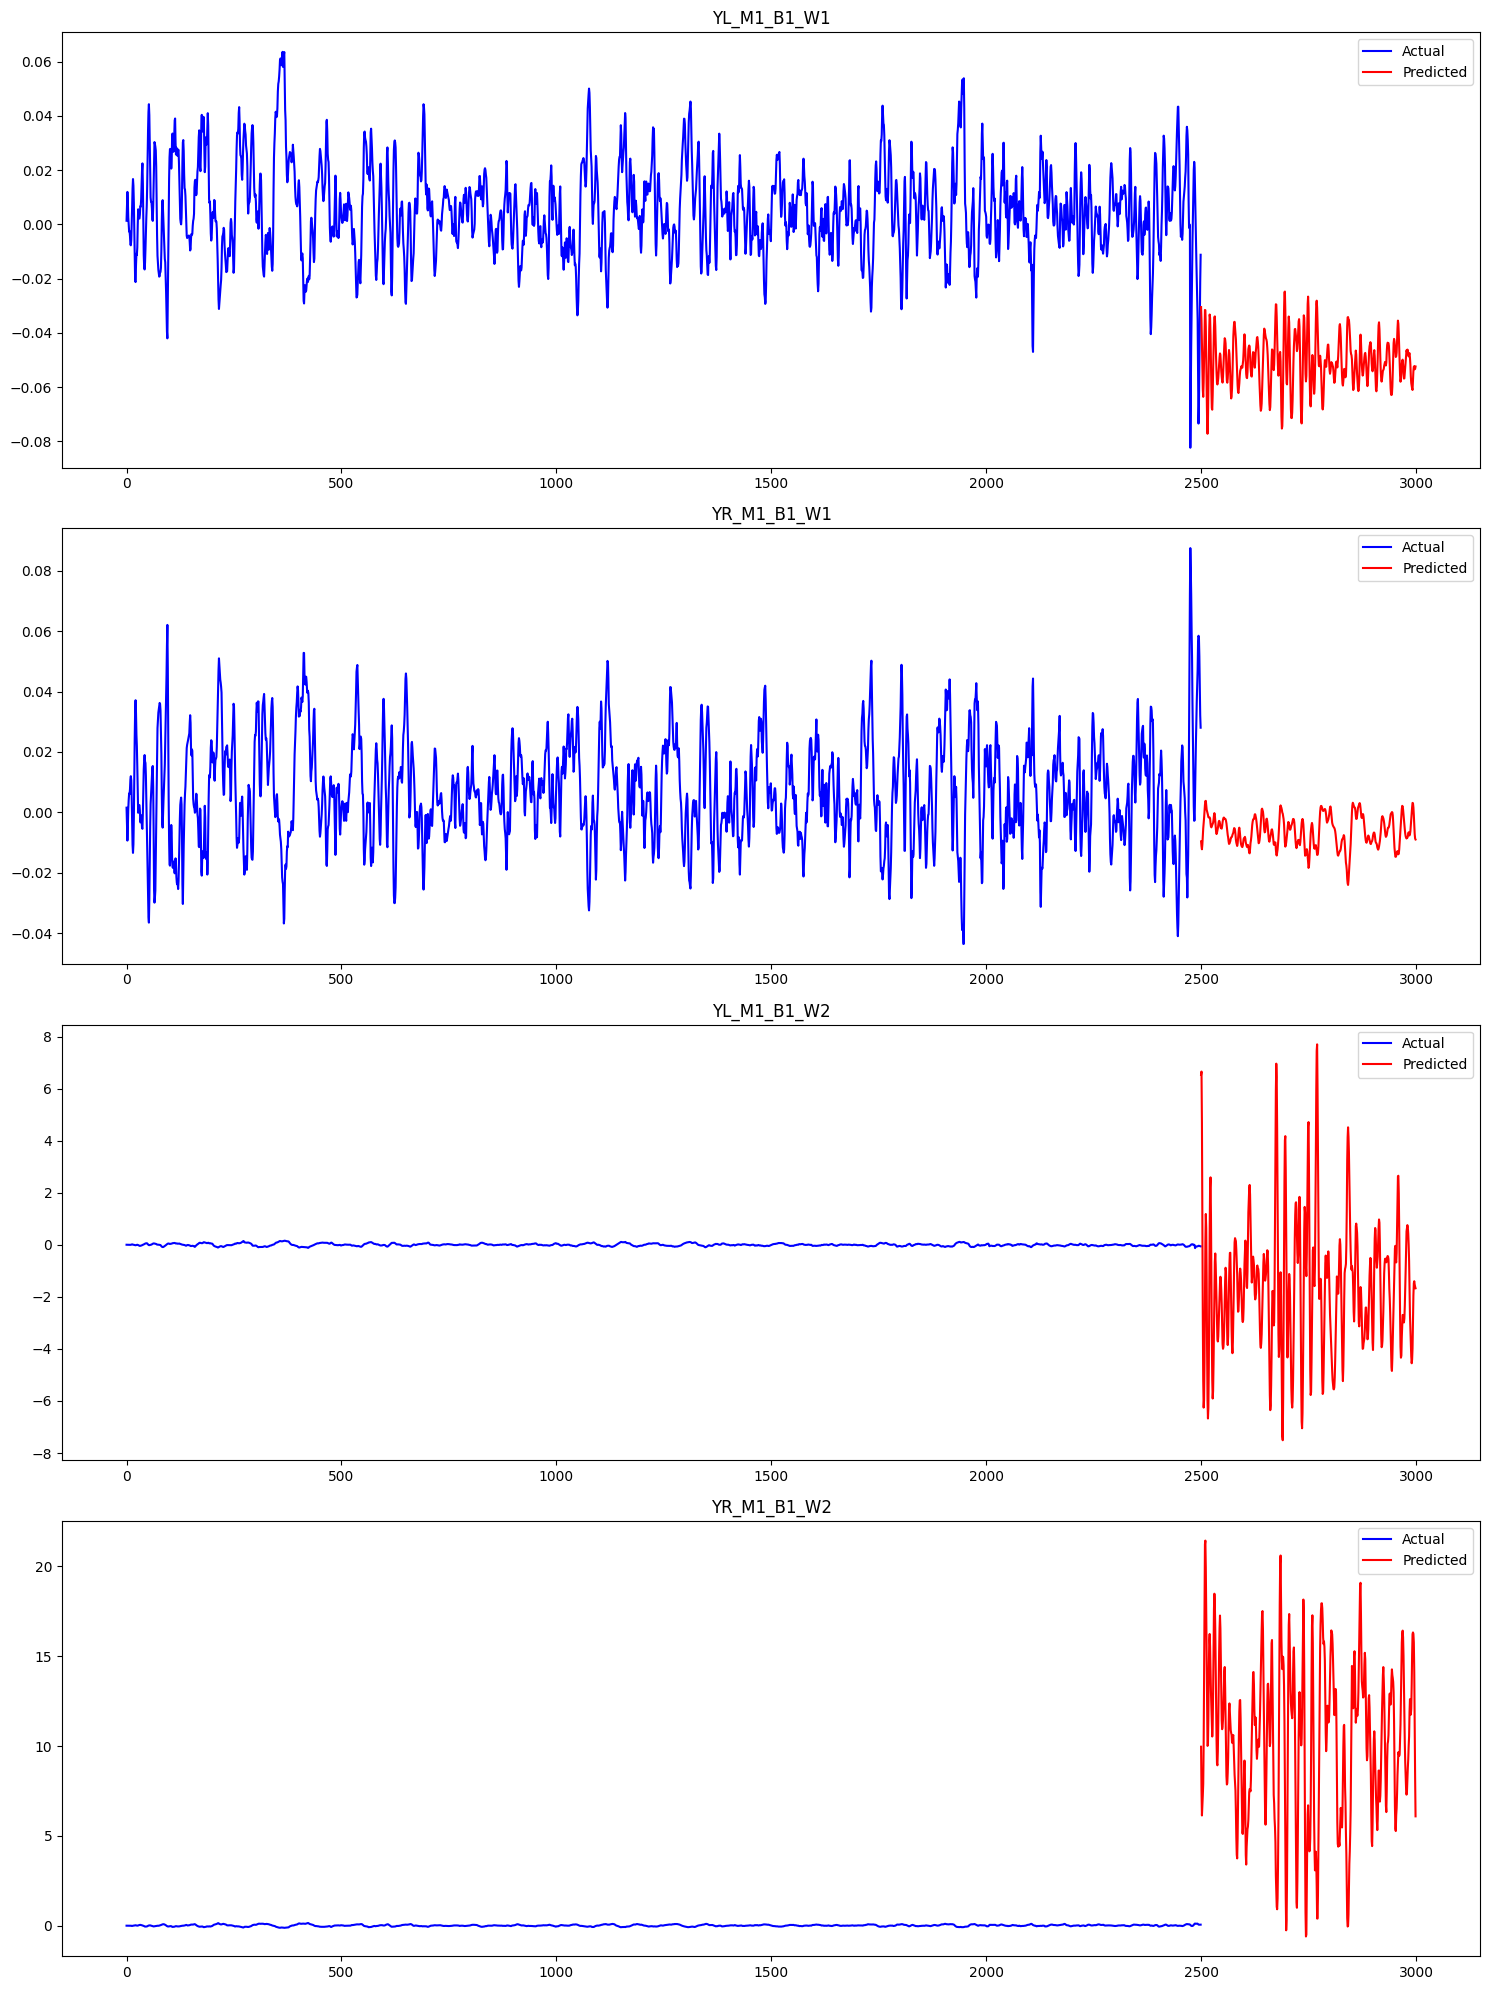

In [50]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

def custom_loss(outputs, targets):
    mse_loss = nn.MSELoss()(outputs, targets)
    regularization_term = torch.mean(torch.abs(outputs))
    return mse_loss + 0.1 * regularization_term

# Load data
train_data_path = "data_c30.csv"
lane_data_path = "lane_data_c.csv"

train_data = pd.read_csv(train_data_path)
lane_data = pd.read_csv(lane_data_path)

# Merge and preprocess data
merged_data = pd.merge(train_data, lane_data, on="Distance", how="left")
merged_data = merged_data.fillna(0)

# Scaling and creating dataset for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data)

# Function to create LSTM dataset remains the same
def create_dataset(data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(data)-look_back):
        dataX.append(data[i:(i+look_back)])
        dataY.append(data[i + look_back, -4:])
    return np.array(dataX), np.array(dataY)

X, y = create_dataset(scaled_data, look_back)

# Splitting data
split_idx = len(scaled_data) - 500 - look_back
X_train = torch.tensor(X[:split_idx], dtype=torch.float32)
y_train = torch.tensor(y[:split_idx], dtype=torch.float32)
X_test = torch.tensor(X[split_idx:], dtype=torch.float32)
y_test = torch.tensor(y[split_idx:], dtype=torch.float32)

# Model definition remains the same
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out

model = LSTMModel(input_dim=X_train.shape[2], hidden_dim=50, output_dim=4, num_layers=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Model training with custom loss
num_epochs = 50
for epoch in range(num_epochs):
    outputs = model(X_train)
    optimizer.zero_grad()

    # Use custom loss
    loss = custom_loss(outputs, y_train)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

# Predictions
model.eval()
with torch.no_grad():
    predictions = model(X_test)

# Inverse scaling
predicted_values = np.zeros_like(scaled_data)
predicted_values[-500:, -4:] = predictions.numpy()
predicted_values = scaler.inverse_transform(predicted_values)
final_predictions = predicted_values[-500:, -4:]

final_predictions[:5]  # Displaying first 5 rows of final predictions for user to verify

import matplotlib.pyplot as plt

# Extract the columns for visualization
actual_values = merged_data[["YL_M1_B1_W1", "YR_M1_B1_W1", "YL_M1_B1_W2", "YR_M1_B1_W2"]].values

fig, axes = plt.subplots(4, 1, figsize=(15, 20))

# YL_M1_B1_W1
axes[0].plot(range(2500), actual_values[:2500, 0], label="Actual", color="blue")
axes[0].plot(range(2500, 3000), final_predictions[:, 0], label="Predicted", color="red")
axes[0].set_title("YL_M1_B1_W1")
axes[0].legend()

# YR_M1_B1_W1
axes[1].plot(range(2500), actual_values[:2500, 1], label="Actual", color="blue")
axes[1].plot(range(2500, 3000), final_predictions[:, 1], label="Predicted", color="red")
axes[1].set_title("YR_M1_B1_W1")
axes[1].legend()

# YL_M1_B1_W2
axes[2].plot(range(2500), actual_values[:2500, 2], label="Actual", color="blue")
axes[2].plot(range(2500, 3000), final_predictions[:, 2], label="Predicted", color="red")
axes[2].set_title("YL_M1_B1_W2")
axes[2].legend()

# YR_M1_B1_W2
axes[3].plot(range(2500), actual_values[:2500, 3], label="Actual", color="blue")
axes[3].plot(range(2500, 3000), final_predictions[:, 3], label="Predicted", color="red")
axes[3].set_title("YR_M1_B1_W2")
axes[3].legend()

plt.tight_layout()
plt.show()
